# Deep Dive into Outliers: Understanding, Detection, and Handling

Outliers are data points that differ significantly from other observations. They can be caused by measurement errors, data entry errors, or natural variations in the data. Understanding how to handle them is crucial for robust data analysis.

**Author:** Muhammad Usman  
**Course:** AI-ka-Chilla 2026

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Setting visualization style
sns.set_theme(style="whitegrid")

## 1. Data Generation
Let's create a synthetic dataset that looks normal but has some extreme values (outliers).

In [2]:
np.random.seed(42)
data = np.random.normal(loc=50, scale=10, size=1000)

# Adding manual outliers
outliers = np.array([10, 15, 90, 95, 120, -10])
data = np.concatenate([data, outliers])

df = pd.DataFrame(data, columns=['value'])
print(f"Initial data count: {len(df)}")
df.describe()

Initial data count: 1006


,value
count,1006.000000
mean,50.212048
std,10.496748
min,-10.000000
25%,43.486391
50%,50.253006
75%,56.498284
max,120.000000


## 2. Visual Detection
The first step in any analysis is visualizing the data. Outliers are often obvious in graphs.

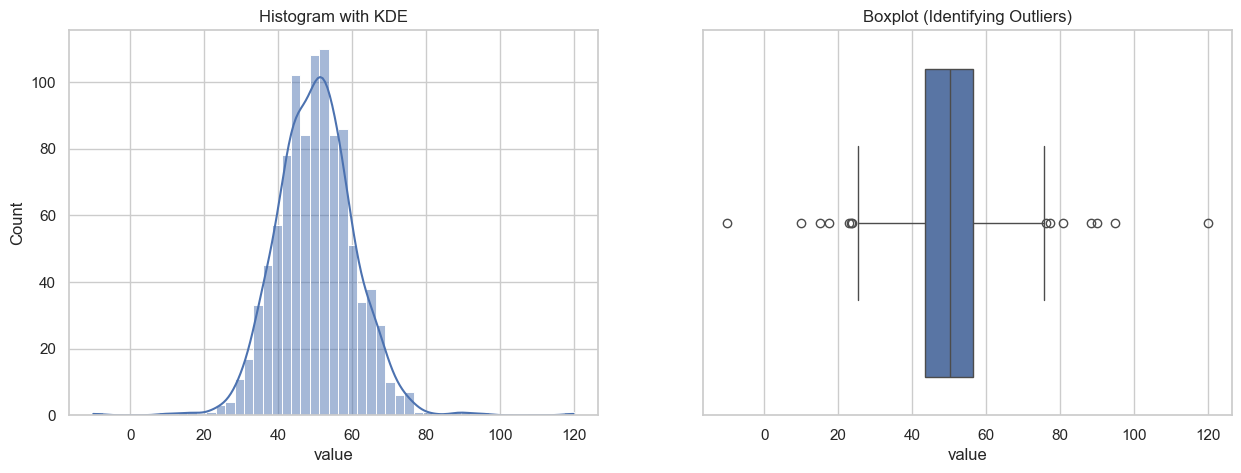

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
sns.histplot(df['value'], kde=True, ax=axes[0])
axes[0].set_title('Histogram with KDE')

# Boxplot
sns.boxplot(x=df['value'], ax=axes[1])
axes[1].set_title('Boxplot (Identifying Outliers)')

plt.show()

## 3. Statistical Detection

### A. Z-Score Method
Z-score tells us how many standard deviations a data point is from the mean. A common threshold is **3** (or -3).

In [4]:
z_scores = np.abs(stats.zscore(df['value']))
outliers_z = df[z_scores > 3]

print(f"Detected {len(outliers_z)} outliers using Z-score method:")
print(outliers_z)

Detected 8 outliers using Z-score method:
           value
209    88.527315
262    17.587327
1000   10.000000
1001   15.000000
1002   90.000000
1003   95.000000
1004  120.000000
1005  -10.000000


### B. Interquartile Range (IQR) Method
IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). 
Anything below $Q1 - 1.5 \times IQR$ or above $Q3 + 1.5 \times IQR$ is considered an outlier.

In [5]:
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Detected {len(outliers_iqr)} outliers using IQR method:")
print(outliers_iqr.head())

Lower Bound: 23.968552094883407
Upper Bound: 76.01612242893246
Detected 14 outliers using IQR method:
         value
74   23.802549
179  77.201692
209  88.527315
262  17.587327
478  80.788808


## 4. Handling Outliers

### A. Trimming (Removal)
Simply removing the outliers from the dataset.

In [6]:
df_trimmed = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]
print(f"New shape after trimming: {df_trimmed.shape}")

New shape after trimming: (992, 1)


### B. Capping (Winsorization)
Instead of removing, we replace outliers with the nearest boundary value (lower or upper bound).

In [7]:
df_capped = df.copy()
df_capped['value'] = np.where(
    df_capped['value'] > upper_bound, 
    upper_bound, 
    np.where(df_capped['value'] < lower_bound, lower_bound, df_capped['value'])
)

print("Descriptive statistics after capping:")
print(df_capped.describe())

Descriptive statistics after capping:
             value
count  1006.000000
mean     50.181372
std       9.887122
min      23.968552
25%      43.486391
50%      50.253006
75%      56.498284
max      76.016122


### C. Log Transformation
Log transformations can reduce the impact of large values.

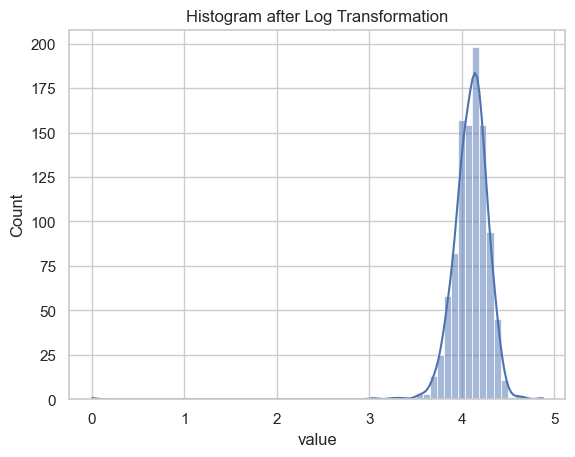

In [8]:
# Adding a constant to deal with negative values if any (though Log is for positive data usually)
df_log = np.log1p(df['value'] - df['value'].min())

sns.histplot(df_log, kde=True)
plt.title("Histogram after Log Transformation")
plt.show()

## Summary
- **Detect first:** Visual tools (Boxplot) are fast; IQR and Z-score are precise.
- **Handle with care:** Don't just delete outliers without understanding *why* they exist. 
- **Capping** is often better than trimming as it preserves the dataset size.